In [1]:
# Import All Modules
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from pinn import PINN
from network import Network
from optimizer import L_BFGS_B
from LDC_Num_Sol import LDC_Num_Sol


In [2]:
#Function to compute flow velocities (u, v) for the network with output (psi, p).
#Args:  xy: network input variables as ndarray.

def uv(network, xy):
    xy = tf.constant(xy)
    with tf.GradientTape() as g:
        g.watch(xy)
        psi_p = network(xy)
    psi_p_j = g.batch_jacobian(psi_p, xy)
    print("The shape of psi_p_j is: ", tf.shape(psi_p_j))
    u =  psi_p_j[..., 0, 1]
    v = -psi_p_j[..., 0, 0]
    return u.numpy(), v.numpy()


In [3]:
#Function to Plot the graphs
def contour(grid, x, y, z, title, levels=50):
    """
    Contour plot.

    Args:
        grid: plot position.
        x: x-array.
        y: y-array.
        z: z-array.
        title: title string.
        levels: number of contour lines.
    """

    # get the value range
    vmin = np.min(z)
    vmax = np.max(z)
    # plot a contour
    plt.subplot(grid)
    plt.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    plt.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))
    plt.title(title)
    cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)

In [4]:
'''Machine Learning Solution'''

# number of training samples
num_train_samples = 15000
# number of test samples
num_test_samples = 100

# inlet flow velocity
u0 = 1
# density
rho = 1
# viscosity
nu = 0.01

# build a core network model
network = Network().build()
network.summary()
# build a PINN model
pinn = PINN(network, rho=rho, nu=nu).build()

# create training input
xy_e = np.random.rand(num_train_samples, 2)
xy_ub = np.random.rand(num_train_samples//2, 2)  # top-bottom boundaries
xy_ub[..., 1] = np.round(xy_ub[..., 1])          # y-position is 0 or 1
xy_lr = np.random.rand(num_train_samples//2, 2)  # left-right boundaries
xy_lr[..., 0] = np.round(xy_lr[..., 0])          # x-position is 0 or 1
xy_b = np.random.permutation(np.concatenate([xy_ub, xy_lr]))
x_train = [xy_e, xy_b]

# create training output
zeros = np.zeros((num_train_samples, 2))
uv_b = np.zeros((num_train_samples, 2))
uv_b[..., 0] = u0 * np.floor(xy_b[..., 1])
y_train = [zeros, zeros, uv_b]

#Trial for model training on adam optimizer
#pinn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#              loss=tf.keras.losses.MeanSquaredError(),
#              metrics= tf.keras.metrics.BinaryAccuracy())
#pinn.fit(x=x_train, y=y_train)


# train the model using L-BFGS-B algorithm
lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
lbfgs.fit()

# create meshgrid coordinates (x, y) for test plots
x = np.linspace(0, 1, num_test_samples)
y = np.linspace(0, 1, num_test_samples)
x, y = np.meshgrid(x, y)
xy = np.stack([x.flatten(), y.flatten()], axis=-1)

# predict (psi, p)
psi_p = network.predict(xy, batch_size=len(xy))
psi, p = [ psi_p[..., i].reshape(x.shape) for i in range(psi_p.shape[-1]) ]

# compute (u, v)
u, v = uv(network, xy)
u = u.reshape(x.shape)
v = v.reshape(x.shape)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,506
Trainable params: 1,506
Non-trainable par

In [5]:
'''Numerical Solution'''

NumSol1 = LDC_Num_Sol(100)
u_num,v_num,p_num =  np.array(NumSol1.solve())


100%|██████████| 10000/10000 [00:51<00:00, 195.08it/s]


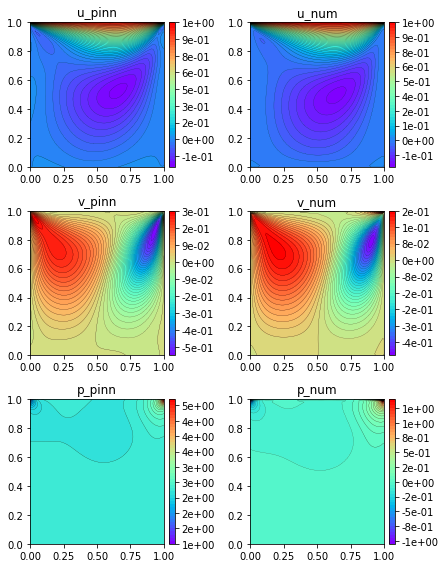

In [9]:
# plot PINN Results
fig = plt.figure(figsize=(9, 8))
gs = GridSpec(3, 3)
contour(gs[0, 0], x, y, u, 'u_pinn')
contour(gs[0, 1], x, y, u_num, 'u_num')
contour(gs[1, 0], x, y, v, 'v_pinn')
contour(gs[1, 1], x, y, v_num, 'v_num')
contour(gs[2, 0], x, y, p, 'p_pinn')
contour(gs[2, 1], x, y, p_num, 'p_num')
plt.tight_layout()
plt.savefig('RE_100.png', bbox_inches='tight')
plt.show()